# Enhancing our pipeline to have better prediction for "Failure Type"

As saw in previous steps, the best models for our binary prediction of "Failure Type" are:
- Logistic Regression,
- SVM,
- Neural Network, 
All tested on original dataset which will be resampled with RUS and SMOTE within respectiv pipeline.

Optimized parameters are found in others notebook via a GridSearch. So now, we will try to test different way to combine the prediction directly on the final prediction

After that, we will be able to combine this prediction with Failure Type prediction to obtain our final y_pred.

#### Importing librairies

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#### Models

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#### Loading datasets

In [3]:
#training
X_train = pd.read_csv('X_train.csv', sep=',')
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]

y_train = pd.read_csv('y_train.csv', sep=',')
y_train_failure_type = y_train['Failure Type']
y_train_failure_type.columns = ['Failure_Type']

#RUS and SMOTE for Failure Type 
X_train_rus_smote = pd.read_csv('X_train_resampled_failure_type.csv', sep=',')
X_train_rus_smote.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train_rus_smote.columns]
y_train_rus_smote = pd.read_csv('y_train_resampled_failure_type.csv', sep=',')
y_train_rus_smote = y_train_rus_smote['Failure Type']
y_train_rus_smote.columns = ['Failure Type']


#testing
X_test = pd.read_csv('X_test.csv', sep=',')
X_test.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_test.columns]

y_test = pd.read_csv('y_test.csv', sep=',')
y_test_failure_type = y_test['Failure Type']
y_test_failure_type.columns = ['Failure Type']


## With Voting Classifier applied on Bagging models

by fitting directly with the RUS + SMOTE dataset

In [31]:
logreg = LogisticRegression(
    max_iter=500, 
    multi_class="ovr")
svm_base = SVC(
    kernel='rbf', 
    C=1, 
    gamma='scale', 
    probability=True, 
    random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(50,50),
                                max_iter=1000,
                                learning_rate_init=0.01,
                                early_stopping=True,
                                n_iter_no_change=20,
                                validation_fraction=0.1,
                                random_state=42)


bag_logreg = BaggingClassifier(
    estimator=logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=svm_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_logreg', bag_logreg),
        ('bag_svm', bag_svm),
        ('bag_nn', bag_nn)
    ],
    voting='soft',     # "soft" uses probabilities which is more appropriate due to multi classes here
    n_jobs=-1
)

voting_clf.fit(X_train_rus_smote, y_train_rus_smote)

y_pred_failure_type = voting_clf.predict(X_test)

Evaluation of Voting Classifier

In [32]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.8617 
Accuracy: 0.7308 
Balanced Accuracy: 0.8617 
F1-score: 0.3603


#### Visualization

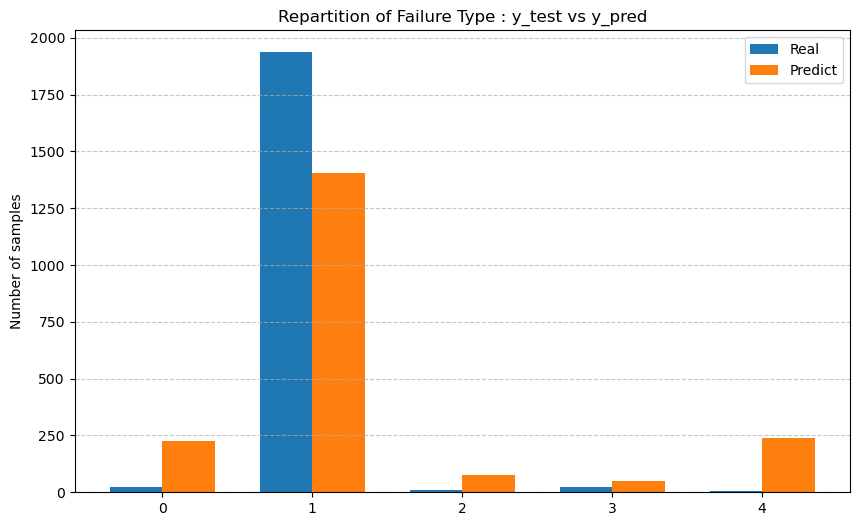

In [33]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [34]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

Real:
 Failure Type
1    1936
0      23
3      23
2       8
4       5
Name: count, dtype: int64 
VS Predict:
 0
1    1405
4     240
0     224
2      76
3      50
Name: count, dtype: int64


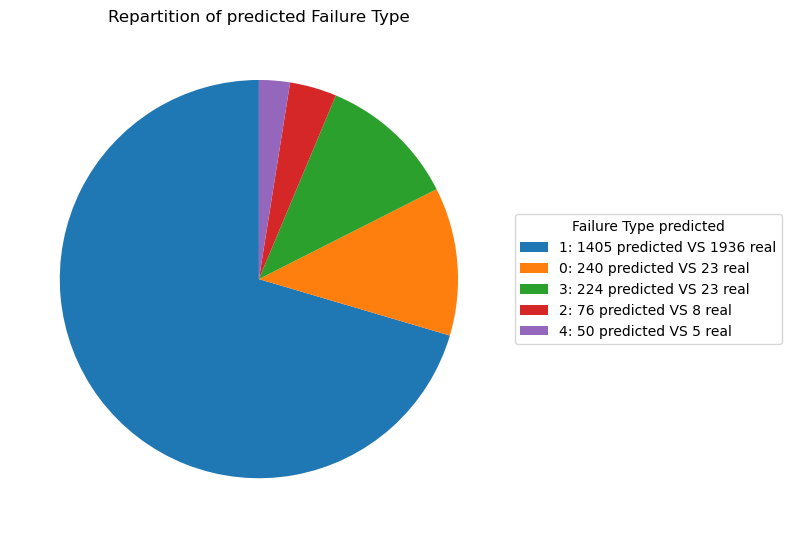

In [35]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type[0].value_counts()

print(f'Real:\n {failure_counts} \nVS Predict:\n {failure_counts_pred}')

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count 
    in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

The recall is pretty high, but the repartition has been very bad predicted. Accuracy is very low.


## With Voting Classifier applied on Bagging models (that are RUS and SMOTE within their pipeline)

In [36]:
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', LogisticRegression(
    max_iter=500, 
    multi_class="ovr")) #parametres a checker avec les filles gridsearch
])

pipe_svm_base = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', SVC(
    kernel='rbf', 
    C=1, 
    gamma='scale', 
    probability=True, 
    random_state=42))
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', MLPClassifier(hidden_layer_sizes=(50,50),
                                max_iter=1000,
                                learning_rate_init=0.01,
                                early_stopping=True,
                                n_iter_no_change=20,
                                validation_fraction=0.1,
                                random_state=42))
])


bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_logreg', bag_logreg),
        ('bag_svm', bag_svm),
        ('bag_nn', bag_nn)
    ],
    voting='soft',     # "soft" uses probabilities which is more appropriate due to multi classes here
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_failure_type)

y_pred_failure_type = voting_clf.predict(X_test)

Evaluation

In [37]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.9260 
Accuracy: 0.7243 
Balanced Accuracy: 0.9260 
F1-score: 0.3592


#### Visualization

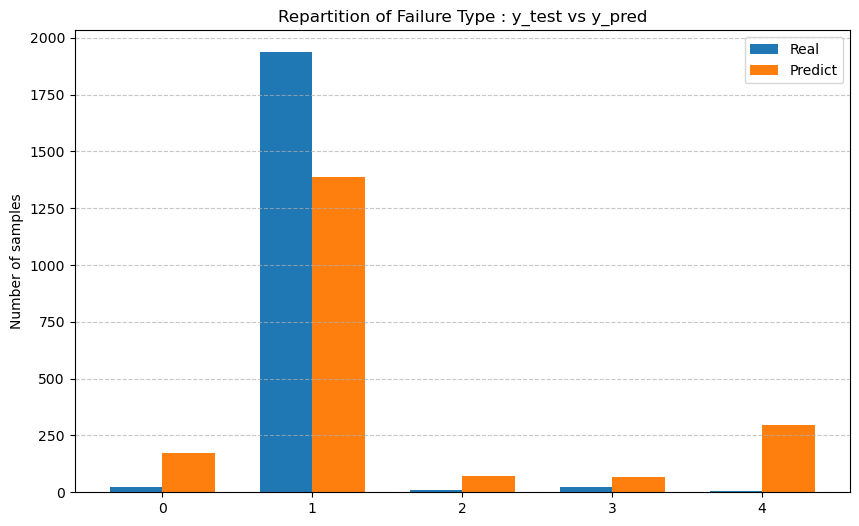

In [38]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [39]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

Real:
 Failure Type
1    1936
0      23
3      23
2       8
4       5
Name: count, dtype: int64 
VS Predict:
 0
1    1388
4     297
0     171
2      72
3      67
Name: count, dtype: int64


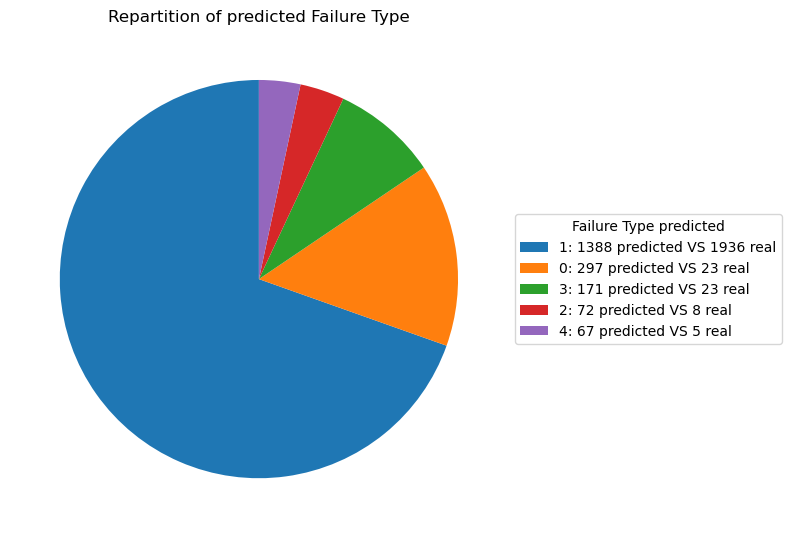

In [40]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type[0].value_counts()

print(f'Real:\n {failure_counts} \nVS Predict:\n {failure_counts_pred}')

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count 
    in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

Too many failure are wrong predicted, and too many failure are predicted as a failure when there must be no failure.

## With Stacking with RUS and SMOTE within the pipeline, with logreg as meta model

In [41]:
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', LogisticRegression(
        max_iter=1000, 
        random_state=42)) #parametres a checker avec les filles gridsearch
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', SVC(
        probability=True, 
        random_state=42))
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', MLPClassifier(
        max_iter=1000, 
        random_state=42))
])


estimators = [
    ('lr', pipe_logreg),
    ('svm', pipe_svm),
    ('nn', pipe_nn)
]

meta = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000, 
    random_state=42)

#stacking classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)


stack.fit(X_train, y_train_failure_type)
probas = stack.predict_proba(X_test)

y_pred_failure_type = stack.predict(X_test)

Evaluation 

In [43]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.9184 
Accuracy: 0.8080 
Balanced Accuracy: 0.9184 
F1-score: 0.4146


In [44]:
print('\nRecall by class:')
for i, r in enumerate(recall_score(y_test_failure_type, y_pred_failure_type, average=None)):
    print(f'  Classe {i} : recall = {r:.4f}')
print(f"Recall_macro (test) = {recall_score(y_test_failure_type, y_pred_failure_type, average='macro'):.4f}")


Recall by class:
  Classe 0 : recall = 0.9130
  Classe 1 : recall = 0.8037
  Classe 2 : recall = 0.8750
  Classe 3 : recall = 1.0000
  Classe 4 : recall = 1.0000
Recall_macro (test) = 0.9184


#### Visualization

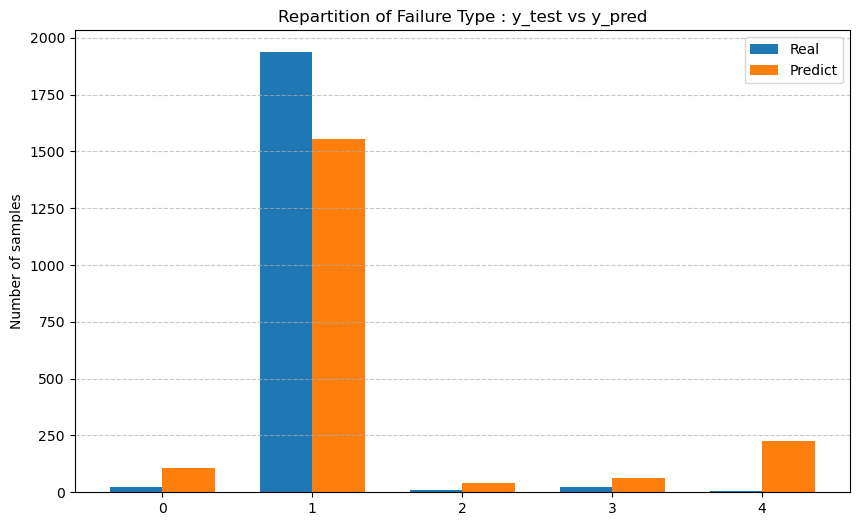

In [45]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [47]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

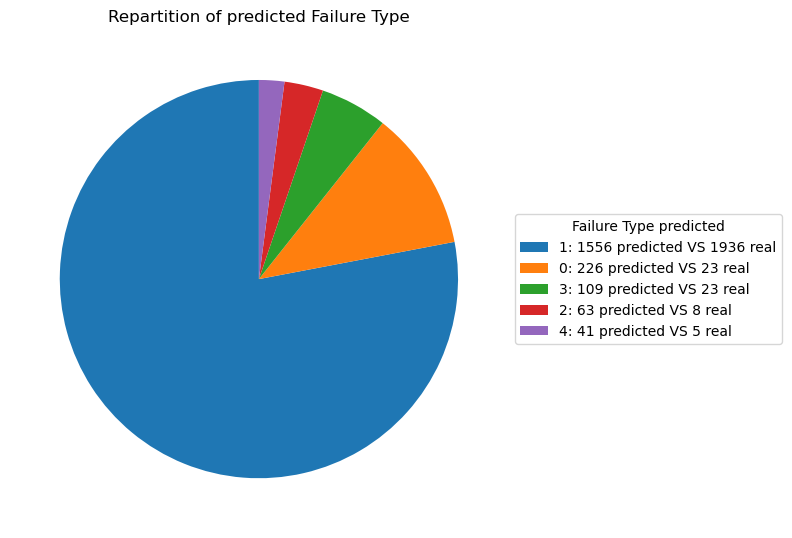

In [48]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type[0].value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

Recall is still high but we got too many predicted failure when there is not as much failure in the real dataset.

## Bagging models for Stacking with Logistic Regression as meta model, RUS and SMOTE within pipelin

Same as previous but bagging the models before Stacking

In [50]:
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression()) #parametres a checker avec les filles gridsearch
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', SVC())
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier())
])

bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

logreg = LogisticRegression()

stacking_clf = StackingClassifier(estimators=[
    ('bag_logreg', bag_logreg),
    ('bag_svm', bag_svm),
    ('bag_nn', bag_nn)], final_estimator=logreg)
stacking_clf.fit(X_train, y_train_failure_type)

y_pred_failure_type = stacking_clf.predict(X_test)

Evaluation

In [51]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.5257 
Accuracy: 0.9835 
Balanced Accuracy: 0.5257 
F1-score: 0.5782


#### Visualization

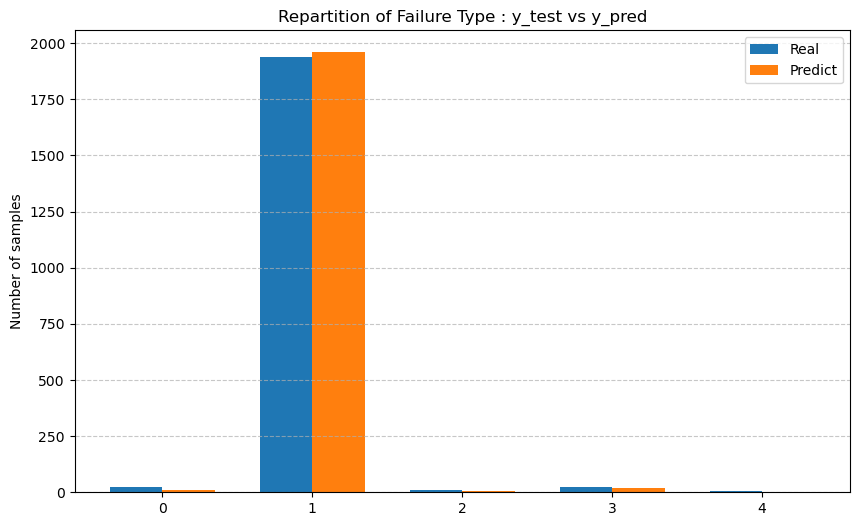

In [52]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [53]:
cm = confusion_matrix(y_test_failure_type, y_pred_failure_type)
cm

array([[   8,   13,    2,    0,    0],
       [   3, 1932,    0,    1,    0],
       [   0,    4,    4,    0,    0],
       [   0,    5,    0,   18,    0],
       [   0,    5,    0,    0,    0]], dtype=int64)

In [54]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

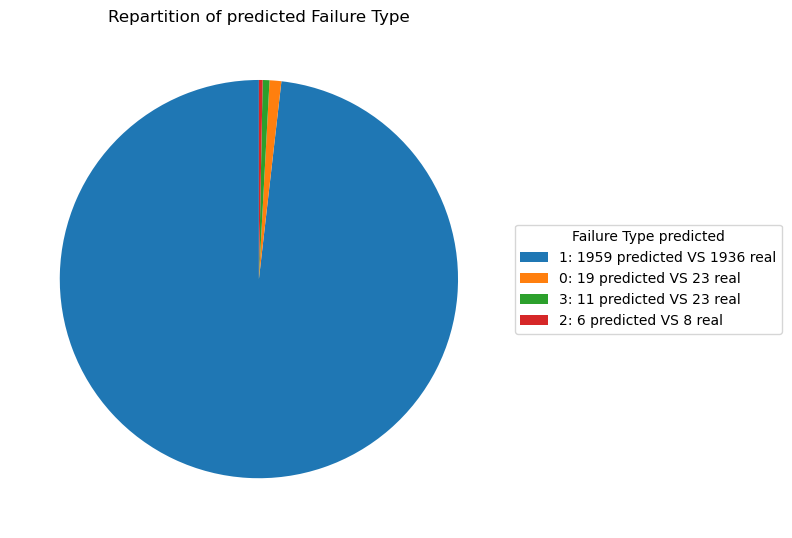

In [55]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type.value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

Even though recall score is not as high as expected, the repartition seems better, with less failures predicted. Given the confusion matrix, we can consider it as a good prediction (high accuracy and precision). 

So far, this is the **best prediction**

## Bagging models for Stacking with bagged Logistic Regression as meta model, and only Neural Network and SVC as base models, RUS and SMOTE within pipelin

In [69]:
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression()) #parametres a checker avec les filles gridsearch
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', SVC())
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier())
])

bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

stacking_clf = StackingClassifier(estimators=[
    ('bag_svm', bag_svm),
    ('bag_nn', bag_nn)], final_estimator=bag_logreg)
stacking_clf.fit(X_train, y_train_failure_type)

y_pred_failure_type = stacking_clf.predict(X_test)

Evaluation

In [70]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.8907 
Accuracy: 0.7469 
Balanced Accuracy: 0.8907 
F1-score: 0.3584


#### Visualization

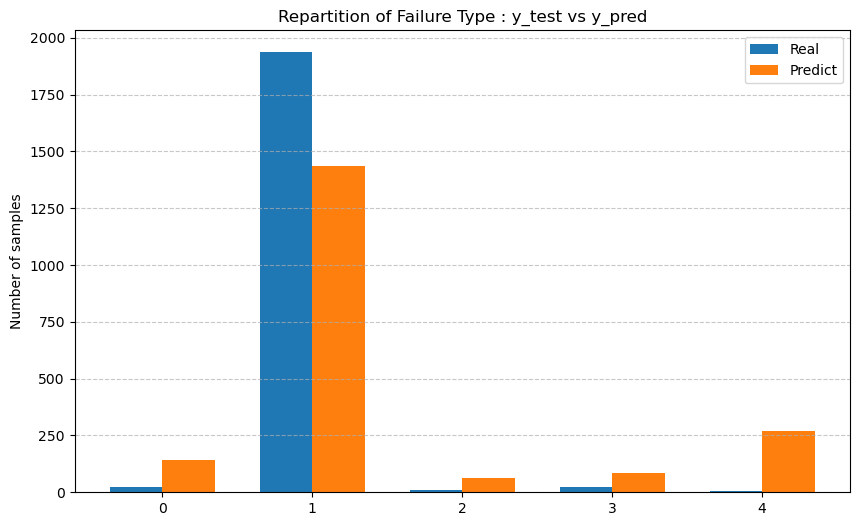

In [71]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [72]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

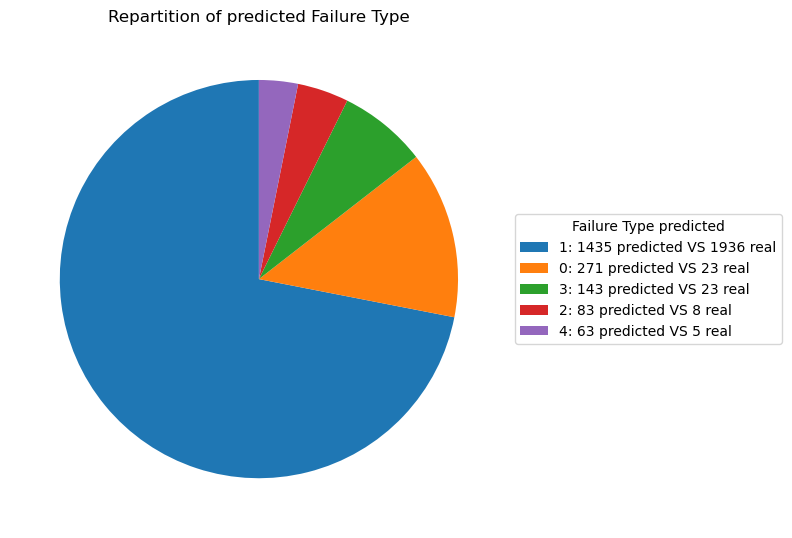

In [73]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type.value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

When the bagging Logistic Regression is used a meta model and not as estimator, recall is way higher as previous case, but repartition is not as good: too many failure for each type.

## Discussion and conclusion

In the final prediction, this prediction will occurs only if a Target is detected. 
Here, the model with highest recall gave us too many failure

The choice will be between: 
#### - Highest recall: 0.92 for Voting Classifier applied on Bagging models (that are RUS and SMOTE within their pipeline)
#### - Highest accuracy: 0.98 and best repartition (not "too many" failure predicted unnecessarly) for Stacking applied on Bagging models (that are RUS and SMOTE within their pipeline) with Logistic Regression as meta model